# Project 1: Web scraping and basic summarization
*University of Ljubljana, Faculty for computer and information science* <br />
*Course: Introduction to data science*



The idea of this Project is to automatically retrieve structured data from pages [rtvslo.si](https://www.rtvslo.si).

## Environment setup

To setup environment we first need to install conda. Conda can be downloaded from: https://docs.conda.io/projects/conda/en/latest/user-guide/install/download.html . Then we need to make new evironment. I used name "upv-project_1" but it can be arbitrary name. Use commands from below to setup environment. 

`ENVIRONMENT SETUP DESCRIPTIONS:
conda create --name upv-project_1
conda activate upv-project_1
conda install python
conda install selenium
conda install jupyter notebook
ipython kernel install --name "upv-project_1" --user
conda install pandas
conda install requests
conda install numpy
conda install matplotlib
conda install scipy`

## Web scraping

We will scrape all whole pages until 1000th article with search key "koronavirus" from  [rtvslo.si](https://www.rtvslo.si) and save data in JSON format.


JSON Schema:

```
[
  {
    "author": ["author_1", "author_2",...],
    "day_published": "DD.MM.YYYY",
    "changed_later": "YES"/"NO", 
    "title": "article_title",
    "subtitle": "article_subtitle",
    "tags": ["tag_1", "tag_2",...],
    "section_tag": "section_tag"
    "content": "article_text",
    "comments": [
        {
            "user": "user_name",
            "date_hour": ["DD.MM.YYYY"; "MM:HH"],
            "grade": comment_grade(as number),
            "reply": "YES"/"NO",
            "comment": "comment_text",

        },...
    ],
    "hour_published": "MM:HH"
    
  }, 
  {
    ...
]


```


In block below are listed all libraries and helper functions needed. Helper functions are imported from helper_f.py file.

In [126]:
# Load all the libraries needed for running the code chunks below

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
import os
from selenium.webdriver.common.by import By
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import matplotlib.dates as mdates


from helper_f import links,  get_article_data,  get_article_comments,  edit_and_join, get_data_skit, get_data_dostopno, get_data_enostavno, make_json_format, change_day_published


First we need to get urls of all articles. Function "links" simulates typing search key "koronavirus" in search bar and navigates trough pages and collects urls of most recent articles and saves them into file "article_urls.txt". Every time we run it we can get new different urls.

In [2]:
#COMMENTED TO CAN NOT ACCIDENTALY OVERWRITE URLS WITH  NEW, MORE RECENT ONES.

main_URL = "https://www.rtvslo.si"
num = 1000 #number of articles, max on rtvslo is 1000
main_key = "Koronavirus"


#links(main_URL, main_key, num) #get 1000 article urls for search key "Koronavirus" and write it into article_urls.txt file


Now we can read url by url from "article_urls.txt" file. I divided urls in 4 categories, based on webpage style and features. Majority of web pages is in let's say normal rtvslo article format (those also can have comments). But some of them are in others "SKIT", "ENOSTAVNO" and "DOSTOPNO" cathegory. Each of them have unique source code. Pages will be scraped depending on cathegory by functions: get_article_data (for normal articles), get_data_skit, get_data_dostopno and get_data_enostavno. Comments from "normal" rtvslo articles wil be collected with function get_article_comments. Data from each article will be saved into own .json file in json folder with make_json_format function . Before scraping each article script will check wether article was already scraped or not. So in case of some interuption it wont need to start from beginning again. 

In [3]:
data = []
data_urls = [] #normal rtvslo articles with no SKIT, ENOSTAVNO, DOSTOPNO articles

enostavno = []
skit = []
dostopno = []
i = 0
print("Started scraping")
file = open('article_urls.txt', 'r', encoding='utf-8')
lines = file.readlines()
for line in lines: #urls 
    if "/enostavno/" in line:
        enostavno.append(line[:-1])
    elif "/skit/" in line:
        skit.append(line[:-1]) #\n has to be removed
    elif "/dostopno/" in line:
        dostopno.append(line[:-1])
    else: #normal ones
        data_urls.append(line[:-1])
        #print("Starting to write url number ", )

        
u = len(data_urls)
s = len(skit)
d = len(dostopno)
e = len(enostavno)
        
for j in range(u): #len data_urls
    if os.path.isfile('json/{}.json'.format(j)): #check if article data was already scraped
        pass
    else: #get article and comments data

        (authors, title, subtitle, date, hour, change, article_tags, section_tag, text) = get_article_data(data_urls[j])
        comments = get_article_comments(data_urls[j])
        line_data = make_json_format(authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments)
        
        data.append(line_data)


        #write to seperate .json file
        with open("json/{}.json".format(j), "w", encoding='utf-8') as outfile:
            json.dump(line_data, outfile, ensure_ascii=False)
            
print("END OF MAIN SCRAPING!!!")


for i in range(s): #len skit
    if os.path.isfile('json/{}.json'.format(u + i)): #check if article data was already scraped
        pass
    else:
        (authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments) = get_data_skit(skit[i])
        line_data = make_json_format(authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments)
        
        data.append(line_data)


        #write to seperate .json file
        with open("json/{}.json".format(i + u), "w", encoding='utf-8') as outfile:
            json.dump(line_data, outfile, ensure_ascii=False)
            
print("END OF SKIT SCRAPING!!!")




for i in range(d):
    if os.path.isfile('json/{}.json'.format(u + s + i)): #check if article data was already scraped
        pass
    else:
        (authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments) = get_data_dostopno(dostopno[i])
        line_data = make_json_format(authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments)
        
        data.append(line_data)


        #write to seperate .json file
        with open("json/{}.json".format(i + u + s), "w", encoding='utf-8') as outfile:
            json.dump(line_data, outfile, ensure_ascii=False)
            
print("END OF DOSTOPNO SCRAPING!!!")


for i in range(e):
    if os.path.isfile('json/{}.json'.format(u + s + i + d)): #check if article data was already scraped
        pass
    else:
        (authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments) = get_data_enostavno(enostavno[i])
        line_data = make_json_format(authors, title, subtitle, date, hour, change, article_tags, section_tag, text, comments)
        
        data.append(line_data)


        #write to seperate .json file
        with open("json/{}.json".format(i + u + s + d), "w", encoding='utf-8') as outfile:
            json.dump(line_data, outfile, ensure_ascii=False)
            
print("END OF ENOSTAVNO SCRAPING!!!")



        
    

Started scraping
END OF MAIN SCRAPING!!!
END OF SKIT SCRAPING!!!
END OF DOSTOPNO SCRAPING!!!
END OF ENOSTAVNO SCRAPING!!!


It takes a lot of time to scrape all the data. I found some typing mistakes but decided not to scrape again but to fix already scraped data. Function in block below edit each .json file and then saves it into folder edited_json_files. It also merges all edited files togather into one big file called data.json

In [4]:
edit_and_join() #fix typos and join all single article json files into one big json file with all the data.
print("Json files fixed and joined into data.json file.")

Json files fixed and joined into data.json file.


## Basic summarization

Prepare and show at least five basic visualizations of the extracted data as presented in the chapter *Summarizing data - the basics* of the course's e-book. Explain each visualization of the data.

In [5]:
#load json file
data_file =  open('data.json', "r", encoding='utf-8')
data = json.load(data_file)
data_file.close()

df = pd.json_normalize(data)
df.head()




,author,day_published,changed_later,title,subtitle,tags,section_tag,content,comments,hour_published
0,[A. P. J.],14.11.2021,YES,V Avstriji od ponedeljka zaprtje države samo z...,Evropa v primežu četrtega vala okužb,"[Avstrija, Nemčija, covid-19, koronavirus]",Novi koronavirus,Dostop do javnih krajev bodo od ponedeljka tak...,"[{'user': 'maIikan', 'date_hour': ['14.11.2021...",12:58
1,[G. C.],13.11.2021,YES,Ministrstvo za izobraževanje šolam posredovalo...,"Učenci in dijaki, ki se ne bodo samotestirali,...","[samotestiranje, protokol, šole]",Novi koronavirus,"Ministrstvo za izobraževanje, znanost in šport...","[{'user': 'one_', 'date_hour': ['13.11.2021', ...",14:04
2,[A. P. J.],13.11.2021,YES,Angela Merkel ob rekordno visoki incidenci poz...,Nizozemska znova delno omejuje javno življenje,"[covid-19, koronavirus, Nemčija]",Novi koronavirus,"""Pred nami so naporni tedni, kot vidite, sem z...","[{'user': 'Kemik', 'date_hour': ['13.11.2021',...",11:56
3,"[T. K. B., G. C., B. R.]",13.11.2021,YES,"Prostih še 9 covidnih intenzivnih postelj, v b...","V petek potrjenih 3666 okužb, umrlo 20 bolnikov","[novi koronavirus, covid-19, statistika, okužb...",Novi koronavirus,Kot je po sestanku za N1 povedal koordinator c...,"[{'user': 'arhitektka', 'date_hour': ['13.11.2...",09:41
4,[Mitja Lisjak],13.11.2021,NO,"Ob obveznem samotestiranju v šolah: ""Kje je sp...",235. MMC-debata o obveznem samotestiranju v šolah,"[MMC-debata, MMCdebata, #MMCdebata, MMC debata...",#MMCdebata,Obvezno samotestiranje na covid-19 učencev in ...,"[{'user': 'maja kibira', 'date_hour': ['13.11....",06:20


In [6]:
df['day'] = pd.to_datetime(df['day_published'], format='%d.%m.%Y') #convert date format to more useful

nm_words = [] #word count
for d in df["content"]:
    ct = len(d.split(" "))
    #print(ct)
    nm_words.append(ct)
    
df["word_number"] = nm_words

nm_comments = []
for d in df["comments"]:
    nm_comments.append(len(d))

df["comment_number"] = nm_comments

df.head(10)




,author,day_published,changed_later,title,subtitle,tags,section_tag,content,comments,hour_published,day,word_number,comment_number
0,[A. P. J.],14.11.2021,YES,V Avstriji od ponedeljka zaprtje države samo z...,Evropa v primežu četrtega vala okužb,"[Avstrija, Nemčija, covid-19, koronavirus]",Novi koronavirus,Dostop do javnih krajev bodo od ponedeljka tak...,"[{'user': 'maIikan', 'date_hour': ['14.11.2021...",12:58,2021-11-14,962,178
1,[G. C.],13.11.2021,YES,Ministrstvo za izobraževanje šolam posredovalo...,"Učenci in dijaki, ki se ne bodo samotestirali,...","[samotestiranje, protokol, šole]",Novi koronavirus,"Ministrstvo za izobraževanje, znanost in šport...","[{'user': 'one_', 'date_hour': ['13.11.2021', ...",14:04,2021-11-13,808,89
2,[A. P. J.],13.11.2021,YES,Angela Merkel ob rekordno visoki incidenci poz...,Nizozemska znova delno omejuje javno življenje,"[covid-19, koronavirus, Nemčija]",Novi koronavirus,"""Pred nami so naporni tedni, kot vidite, sem z...","[{'user': 'Kemik', 'date_hour': ['13.11.2021',...",11:56,2021-11-13,868,112
3,"[T. K. B., G. C., B. R.]",13.11.2021,YES,"Prostih še 9 covidnih intenzivnih postelj, v b...","V petek potrjenih 3666 okužb, umrlo 20 bolnikov","[novi koronavirus, covid-19, statistika, okužb...",Novi koronavirus,Kot je po sestanku za N1 povedal koordinator c...,"[{'user': 'arhitektka', 'date_hour': ['13.11.2...",09:41,2021-11-13,737,377
4,[Mitja Lisjak],13.11.2021,NO,"Ob obveznem samotestiranju v šolah: ""Kje je sp...",235. MMC-debata o obveznem samotestiranju v šolah,"[MMC-debata, MMCdebata, #MMCdebata, MMC debata...",#MMCdebata,Obvezno samotestiranje na covid-19 učencev in ...,"[{'user': 'maja kibira', 'date_hour': ['13.11....",06:20,2021-11-13,466,29
5,[A. G.],12.11.2021,NO,V prvem krogu EP-ja v Čatežu zmagala le prva s...,Dekleta brez Laure Unuk izgubile proti Belgiji...,"[Matej Šebenik, Jure Borišek, Lara Janželj, šah]",Preostali športi,"Prva ženska vrsta, 15. nosilka, je proti Belgi...","[{'user': 'acrje', 'date_hour': ['13.11.2021',...",22:26,2021-11-12,664,3
6,[B. V.],12.11.2021,YES,"Med deseterico članic EU-ja, ki se najslabše s...",V Sloveniji se okužbe širijo najhitreje v Unij...,"[Novi koronavirus, ECDC, Slovenija]",Novi koronavirus,"V svoji redni tedenski oceni ECDC ugotavlja, d...","[{'user': 'Moots', 'date_hour': ['12.11.2021',...",18:22,2021-11-12,301,65
7,[J. R.],12.11.2021,NO,Ameriška olimpijka Sunisa Lee žrtev rasistične...,"""Bila sem zelo jezna, a nisem mogla ničesar na...","[Sunisa Lee, rasistični napad, ZDA]",S. in J. Amerika,"V intervjuju za Pop Sugar je razkrila, da je b...","[{'user': 'mrclaggart', 'date_hour': ['12.11.2...",13:11,2021-11-12,249,7
8,"[J. R., B. V.]",12.11.2021,YES,Danska znova uvedla uporabo covidnega potrdila...,Nemčija uvrstila Avstrijo med območja z visoki...,"[Danska, covidno potrdilo, covid-19, koronavirus]",Novi koronavirus,Covidno potrdilo bo obvezno predvsem za obisk ...,"[{'user': 'Burshopeli', 'date_hour': ['12.11.2...",11:59,2021-11-12,2041,131
9,"[M. Z., A. K. K., G. C.]",12.11.2021,YES,IJS: Pri številu potrjenih okužb smo že dosegl...,Na covidnem oddelku UKC-ja je pomagal tudi min...,"[novi koronavirus, covid-19, okužbe]",Novi koronavirus,Predvidoma bo na intenzivnih oddelkih več kot...,"[{'user': 'RESNICA1977', 'date_hour': ['12.11....",08:27,2021-11-12,1062,318


### Visualization 1

C:\Users\zaloz\AppData\Local\Temp/ipykernel_8204/1113844899.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["day_name"] = df['day'].dt.day_name()
C:\Users\zaloz\AppData\Local\Temp/ipykernel_8204/1113844899.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['day_name'] = pd.Categorical(df3['day_name'], categories=


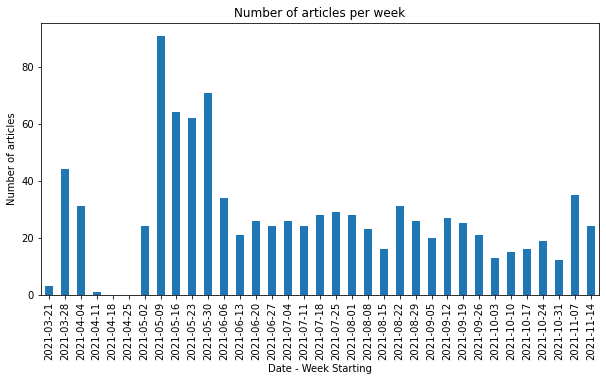

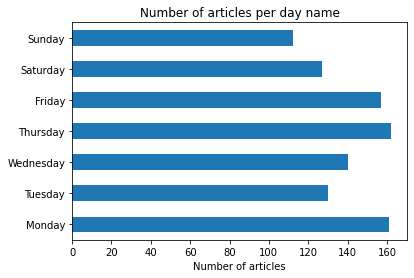

In [146]:
df1 = df[["day", "changed_later"]]
data1 = df1.sort_values('day').set_index('day')
week_groups_resample = data1.resample('W').count()



df2 = df[["day"]]
df2["day_name"] = df['day'].dt.day_name()
#df3 = df2.groupby("day_name").count()
#df3.plot(kind = "barh", legend=None)


df3 = df2[["day_name"]]
df3['day_name'] = pd.Categorical(df3['day_name'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

counts = df3["day_name"].value_counts()
sorted_by_day_name = counts.sort_index()




ax = week_groups_resample.plot(kind='bar',
                               figsize=(10,5),legend=None)
ax.set_xticklabels(week_groups_resample.index.strftime('%Y-%m-%d'), rotation=90)
plt.xlabel('Date - Week Starting');
plt.ylabel('Number of articles');
plt.title("Number of articles per week")
plt.show()






sorted_by_day_name.plot(kind='barh')
plt.title('Number of articles per day name')
plt.ylabel('')
plt.xlabel('Number of articles')
plt.show()



### Visualization 2

`TODO: name the visualization and describe it`

In [8]:
df.groupby("section_tag").count()


bla = df['section_tag'].value_counts()
a = df.section_tag.mode(10)
bla.head(10)

Novi koronavirus    503
Slovenija            68
Evropa               40
Preberite tudi       31
Ture avanture        28
ENOSTAVNO            20
S. in J. Amerika     16
Gospodarstvo         16
DOSTOPNO             13
Svet                 12
Name: section_tag, dtype: int64

,author,day_published,changed_later,title,subtitle,tags,section_tag,content,comments,hour_published,day,word_number,comment_number
0,[A. P. J.],14.11.2021,YES,V Avstriji od ponedeljka zaprtje države samo z...,Evropa v primežu četrtega vala okužb,"[Avstrija, Nemčija, covid-19, koronavirus]",Novi koronavirus,Dostop do javnih krajev bodo od ponedeljka tak...,"[{'user': 'maIikan', 'date_hour': ['14.11.2021...",12:58,2021-11-14,962,178
1,[G. C.],13.11.2021,YES,Ministrstvo za izobraževanje šolam posredovalo...,"Učenci in dijaki, ki se ne bodo samotestirali,...","[samotestiranje, protokol, šole]",Novi koronavirus,"Ministrstvo za izobraževanje, znanost in šport...","[{'user': 'one_', 'date_hour': ['13.11.2021', ...",14:04,2021-11-13,808,89
2,[A. P. J.],13.11.2021,YES,Angela Merkel ob rekordno visoki incidenci poz...,Nizozemska znova delno omejuje javno življenje,"[covid-19, koronavirus, Nemčija]",Novi koronavirus,"""Pred nami so naporni tedni, kot vidite, sem z...","[{'user': 'Kemik', 'date_hour': ['13.11.2021',...",11:56,2021-11-13,868,112


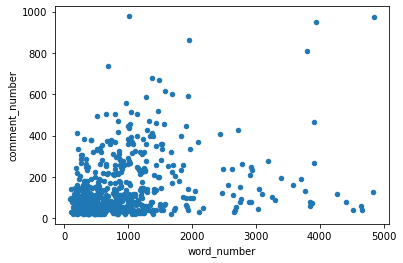

In [58]:

num_comments = df["comment_number"] 
len_text = df["word_number"]
d_f= df[df["comment_number"] > 20]
d_f.plot.scatter('word_number', "comment_number")
d_f.head(3)

### Visualization 3

`TODO: name the visualization and describe it`

In [10]:
bla = df.groupby("changed_later")

y_n = df["changed_later"].value_counts()       
y_n_section = bla["section_tag"].value_counts()       


blabla = df.groupby("section_tag")
section_y_n = blabla["changed_later"].value_counts()

df["section_tag"].value_counts()
y_n_section
d = section_y_n.to_dict()
l = y_n_section.to_dict()




In [59]:
#data for visualization 4 and 5
article_lengths = []
comm_date = []
comm_time = [] #only full hours
comm_lengths = []
good_comm = []
not_replies = []
for article in data:
    article_lengths.append(len(article["content"].split(" ")))
    
    for comm in article["comments"]:
        date, time = comm["date_hour"]
        comm_date.append(date)
        comm_time.append(time)
        length = len(comm["comment"].split(" "))
        comm_lengths.append(length)
        if int(comm["grade"]) > 20:
            good_comm.append(length)

{'user': 'maIikan',
 'date_hour': ['14.11.2021', '13:28'],
 'grade': 4,
 'reply': 'NO',
 'comment': 'Še ena država, ki je zapadla v masovno histerijo in paranojo, ki ničesar ne bo rešila. Cepljenje mladih ne igra vloge. Hkrati pa cepljeni naokoli prenašajo virus. Avstrija bo žal napako spoznala prepozno.'}

### Visualization 4

`TODO: name the visualization and describe it`

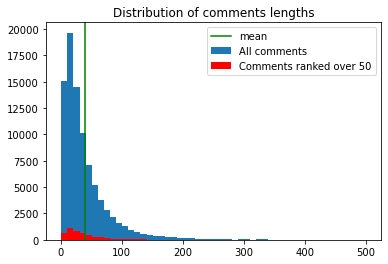

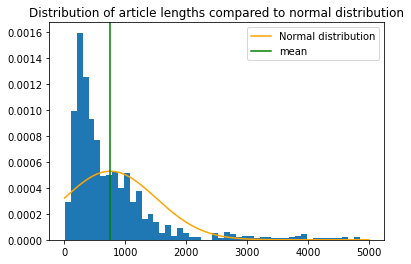

In [62]:
# Visualization 4 code

#distribution of data and text llength instead of scatter plot

        
        

plt.figure()
comm_mean = np.mean(comm_lengths)
plt.hist(comm_lengths, bins = 50, range=(1,500), density=False, label="All comments")
comm_std = np.std(comm_lengths)
X = np.linspace(0,500, 1000)
#plt.plot(X, stats.norm.pdf(X, comm_mean, comm_std), label = "Normal distribution")
plt.axvline(x=comm_mean, color="green", label= "mean")
#plt.axvline(x=np.mean(good_comm), color="green", label= "mean")
plt.hist(good_comm, bins=50, density=False, color="red",  range=(1,500), label="Comments ranked over 50")
plt.title("Distribution of comments lengths")
plt.legend()
plt.show()


art_std = np.std(article_lengths)
art_mean = np.mean(article_lengths)

plt.figure()
X = np.linspace(1,5000,1000)
plt.plot(X, stats.norm.pdf(X, art_mean, art_std), label = "Normal distribution", color="orange")
plt.axvline(x=art_mean, color="green", label= "mean")
plt.hist(article_lengths, bins=50, density=True, )

plt.legend()
plt.title("Distribution of article lengths compared to normal distribution")
plt.show()





### Visualization 5

`TODO: name the visualization and describe it`

In [ ]:
#comments per hour between week and between weekends

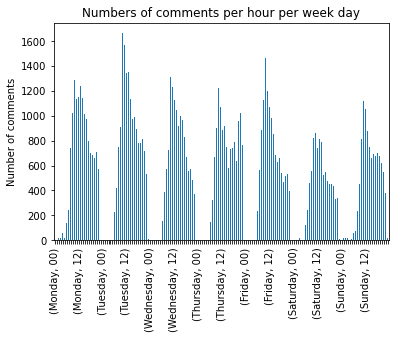

In [145]:
plot_5 = pd.DataFrame(list(zip(comm_date, comm_time)),
               columns =['day', 'hour'])

plot_5["hour"] = plot_5['hour'].apply(lambda x: x[:2])
plot_5['day'] = pd.to_datetime(plot_5['day'], format='%d.%m.%Y')
plot_5_f= plot_5[['hour']]  
plot_5_f['day_name'] = plot_5['day'].dt.day_name()
plot_5_f['day_name'] = pd.Categorical(plot_5_f['day_name'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
   ordered=True)

plot_5_f.set_index('day_name')
plot_data = plot_5_f.groupby(["day_name", "hour"]).size()


fig, ax = plt.subplots()

plot_data.plot(kind="bar", title=("Numbers of comments per hour per week day"))

every_nth = 12
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xlabel("")
plt.ylabel("Number of comments")
plt.show()


